Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


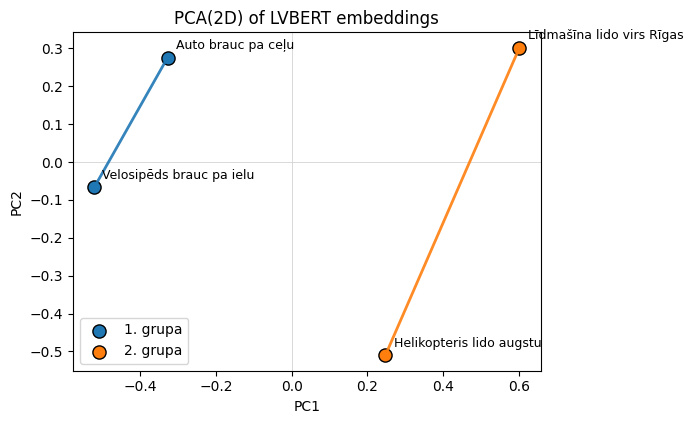

Cosine similarities:
1. grupa: Velosipēds brauc pa ielu  ↔  Auto brauc pa ceļu  =  0.6660
2. grupa: Līdmašīna lido virs Rīgas  ↔  Helikopteris lido augstu  =  0.5593


In [ ]:
# LV-BERT embeddings

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

group_1 = ["Velosipēds brauc pa ielu", "Auto brauc pa ceļu"]
group_2 = ["Līdmašīna lido virs Rīgas", "Helikopteris lido augstu"]

items = group_1 + group_2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "AiLab-IMCS-UL/lvbert"
tok = AutoTokenizer.from_pretrained(model_name)
enc = AutoModel.from_pretrained(model_name).to(device)
enc.eval()

def embed(texts):
    with torch.no_grad():
        batch = tok(texts, padding=True, truncation=True, return_tensors="pt").to(device)
        hidden = enc(**batch).last_hidden_state
        mask = batch["attention_mask"].unsqueeze(-1).float()
        emb = (hidden * mask).sum(dim=1) / mask.sum(dim=1)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
    return emb.cpu().numpy()

vecs = embed(items)
sim_group_1 = cosine_similarity(vecs[0:1], vecs[1:2])[0,0]
sim_group_2     = cosine_similarity(vecs[2:3], vecs[3:4])[0,0]

pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(vecs)

xy_uni = xy[:2]
xy_nat = xy[2:]

plt.figure(figsize=(7,6))
ax = plt.gca()
ax.axhline(0, lw=0.6, color="lightgrey")
ax.axvline(0, lw=0.6, color="lightgrey")
ax.set_aspect('equal', adjustable='box')

uni_color = "C0"
nat_color = "C1"

plt.scatter(xy_uni[:,0], xy_uni[:,1], s=90, color=uni_color, label="1. grupa", edgecolor="k")
plt.scatter(xy_nat[:,0], xy_nat[:,1], s=90, color=nat_color, label="2. grupa", edgecolor="k")

plt.plot(xy_uni[:,0], xy_uni[:,1], color=uni_color, linewidth=2, alpha=0.9)
plt.plot(xy_nat[:,0], xy_nat[:,1], color=nat_color, linewidth=2, alpha=0.9)

labels = items
for (x, y, lab) in zip(xy[:,0], xy[:,1], labels):
    plt.annotate(lab, (x, y), textcoords="offset points", xytext=(6,6), fontsize=9)

def annotate_pair_similarity(pair_xy, sim_value, color):
    mid = pair_xy.mean(axis=0)

annotate_pair_similarity(xy_uni, sim_group_1, uni_color)
annotate_pair_similarity(xy_nat, sim_group_2,     nat_color)

plt.title("PCA(2D) of LVBERT embeddings")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

print("Cosine similarities:")
print(f"1. grupa: {group_1[0]}  ↔  {group_1[1]}  =  {sim_group_1:.4f}")
print(f"2. grupa: {group_2[0]}  ↔  {group_2[1]}  =  {sim_group_2:.4f}")
